In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import keras
import pathlib
import PIL
from PIL import Image
from imgaug import augmenters as iaa
from keras.applications.xception import Xception
from keras.models import Model
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import pandas as pd
from IPython.display import display

## Initialize

In [2]:
PATH = "awe"
TRAIN_PATH = "TrainData"
total_subjects = 100
epochs = 100 
img_size = 200
batch_size = 128
data_dir = pathlib.Path("awe/TrainData")
          
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 2)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Load data

In [3]:
training_dataset = keras.preprocessing.image_dataset_from_directory(
    "awe\TrainData",
    labels='inferred',
    subset="training",
    seed=123,
    validation_split=0.2,                                                             
    batch_size=batch_size,
    image_size=(img_size, img_size))

validation_dataset = keras.preprocessing.image_dataset_from_directory(
    "awe\TrainData",
    labels='inferred',
    subset="validation",
    seed=123,
    validation_split=0.2,                                                             
    batch_size=batch_size,
    image_size=(img_size, img_size))

class_names = training_dataset.class_names

Found 1000 files belonging to 100 classes.
Using 800 files for training.
Found 1000 files belonging to 100 classes.
Using 200 files for validation.


## Configure the dataset for performance

In [4]:
AUTOTUNE = tf.data.AUTOTUNE

training_dataset = training_dataset.cache().prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.cache().prefetch(buffer_size=AUTOTUNE)

## Model

### Init 

In [5]:
nb_filters = 64
pool_size = 4
kernel_size = 10
input_shape = (img_size, img_size, 1)  # dimenstion

### Data Augmentation

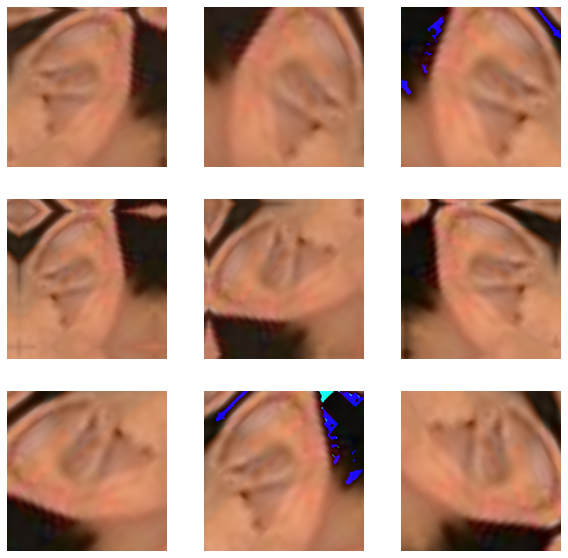

In [6]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_size,img_size,3)),
    layers.experimental.preprocessing.RandomRotation(0.2),
    layers.experimental.preprocessing.RandomZoom(0.2),
    layers.experimental.preprocessing.RandomContrast(0.2)])

plt.figure(figsize=(10, 10))
for images, _ in training_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [7]:
model = tf.keras.Sequential([
    data_augmentation,
    layers.experimental.preprocessing.Rescaling(1./255),
    layers.Conv2D(6,kernel_size,input_shape=input_shape, strides=1), # conv 1
    layers.AveragePooling2D(pool_size,strides=2),
    #layers.Dropout(0.2),
    layers.Conv2D(12,kernel_size,strides=1), # conv 2
    layers.AveragePooling2D(pool_size,strides=2),
    #layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(total_subjects),  # num_classes
    layers.Activation('softmax')
])


In [8]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [9]:
history = model.fit(
    training_dataset,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=validation_dataset,
)

print(history.history)
print('Train loss:', history.history['loss'])
print('Train accuracy:', history.history['accuracy'])
print('Test loss:', history.history['val_loss'])
print('Test accuracy:', history.history['val_accuracy'])

Epoch 1/100
7/7 [==============================] - 7s 351ms/step - loss: 5.9702 - accuracy: 0.0051 - val_loss: 5.9979 - val_accuracy: 0.0150
Epoch 2/100
7/7 [==============================] - 1s 76ms/step - loss: 5.7848 - accuracy: 0.0052 - val_loss: 4.6510 - val_accuracy: 0.0300
Epoch 3/100
7/7 [==============================] - 1s 76ms/step - loss: 4.7211 - accuracy: 0.0272 - val_loss: 4.8619 - val_accuracy: 0.0100
Epoch 4/100
7/7 [==============================] - 1s 76ms/step - loss: 4.7417 - accuracy: 0.0191 - val_loss: 4.7052 - val_accuracy: 0.0000e+00
Epoch 5/100
7/7 [==============================] - 1s 76ms/step - loss: 4.5793 - accuracy: 0.0323 - val_loss: 4.7401 - val_accuracy: 0.0250
Epoch 6/100
7/7 [==============================] - 1s 76ms/step - loss: 4.5633 - accuracy: 0.0241 - val_loss: 4.6080 - val_accuracy: 0.0350
Epoch 7/100
7/7 [==============================] - 1s 75ms/step - loss: 4.4281 - accuracy: 0.0400 - val_loss: 4.5191 - val_accuracy: 0.0550
Epoch 8/100
7/7

7/7 [==============================] - 1s 77ms/step - loss: 2.9670 - accuracy: 0.3107 - val_loss: 4.3161 - val_accuracy: 0.1150
Epoch 60/100
7/7 [==============================] - 1s 82ms/step - loss: 2.9662 - accuracy: 0.2977 - val_loss: 4.3541 - val_accuracy: 0.1200
Epoch 61/100
7/7 [==============================] - 1s 77ms/step - loss: 2.9851 - accuracy: 0.3048 - val_loss: 4.2918 - val_accuracy: 0.1450
Epoch 62/100
7/7 [==============================] - 1s 77ms/step - loss: 3.0478 - accuracy: 0.2764 - val_loss: 4.3457 - val_accuracy: 0.1300
Epoch 63/100
7/7 [==============================] - 1s 77ms/step - loss: 2.9668 - accuracy: 0.2769 - val_loss: 4.5241 - val_accuracy: 0.1200
Epoch 64/100
7/7 [==============================] - 1s 77ms/step - loss: 3.0387 - accuracy: 0.2790 - val_loss: 4.3603 - val_accuracy: 0.1150
Epoch 65/100
7/7 [==============================] - 1s 77ms/step - loss: 2.8368 - accuracy: 0.3026 - val_loss: 4.3652 - val_accuracy: 0.1300
Epoch 66/100
7/7 [========

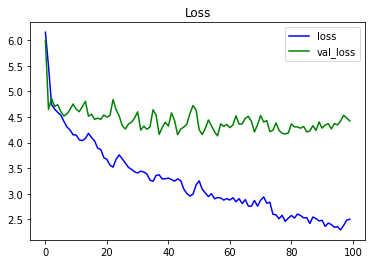

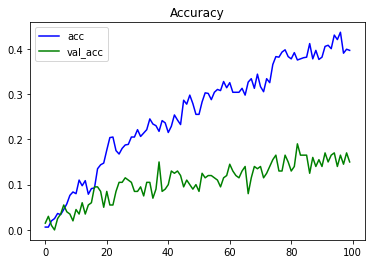

Test loss: 4.422898769378662
Test accuracy: 0.15000000596046448


In [10]:
loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
x = range(len(acc))

plt.figure()
plt.title("Loss")
plt.plot(x, loss, 'b', label='loss')
plt.plot(x, val_loss, 'g', label = 'val_loss' )
plt.legend()
plt.show()

plt.figure()
plt.title("Accuracy")
plt.plot(x, acc, 'b', label='acc')
plt.plot(x, val_acc, 'g', label ='val_acc')
plt.legend()
plt.show()

score = model.evaluate(validation_dataset, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

## Prediction

In [11]:
subject = '088'

subject_folder = list(data_dir.glob(subject+'/*'))
img = PIL.Image.open(str(subject_folder[0]))

img = keras.preprocessing.image.load_img(
         subject_folder[0], target_size=(img_size, img_size))

img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)
print("Real subject: ", subject)

This image most likely belongs to 043 with a 1.26 percent confidence.
Real subject:  088
